# Optimize ECG Classification

###### Classify ECGs into one of 5 classes: class0:N, class1:S, class2:V, class3:F, class4:Q

## Random Fourier feature GLM(Generalized Linear Model): good for imbalanced data

Random Fourier Features (RFF) are a technique used to approximate the kernel trick in machine learning algorithms. When applied to Generalized Linear Models (GLMs), RFF can provide benefits in terms of computational efficiency and scalability.

GLMs are a class of models that generalize linear regression by allowing for non-linear relationships between the input features and the response variable. The traditional approach to GLMs involves specifying a fixed basis function, such as polynomial or Gaussian basis functions, to capture non-linearities in the data. However, this can become computationally expensive and impractical for large datasets.

RFF offers an alternative approach by leveraging random projections and Fourier transforms to approximate the non-linear kernel functions typically used in kernel methods. This allows for efficient computation and enables the application of GLMs to high-dimensional or even infinite-dimensional feature spaces.

The basic idea behind RFF GLMs is to map the input features into a high-dimensional feature space using random Fourier features. These random features are obtained by randomly generating weights and biases and combining them with the input features using Fourier transformations. The resulting transformed features can then be used as inputs to a GLM.

By using RFF, the computational complexity of GLMs can be significantly reduced. Instead of explicitly computing the kernel matrix, which can be computationally expensive for large datasets, RFF allows for efficient computation by using simple matrix multiplications and element-wise trigonometric functions. Moreover, RFF has been shown to preserve the statistical properties of the original kernel methods, making it a reliable approximation technique.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

E:\Downloads\ANACONDA3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
E:\Downloads\ANACONDA3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
E:\Downloads\ANACONDA3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
E:\Downloads\ANACONDA3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## MIT DATASET 

### Looking at dataset 

In [3]:
trainpath = "./2016_edition_augmented/mitbih_train.csv"
x_train = pd.read_csv(trainpath,header=None, usecols=range(187))
y_train = pd.read_csv(trainpath,header=None, usecols=[187]).iloc[:,0]
x_train.shape

(87554, 187)

In [3]:
testpath = "./2016_edition_augmented/mitbih_test.csv"
x_test = pd.read_csv(testpath,header=None, usecols=range(187))
y_test = pd.read_csv(testpath,header=None, usecols=[187]).iloc[:,0]
x_test.shape

(21892, 187)

In [4]:
x_test.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
19207,0.928713,1.000000,0.928713,0.841584,0.786139,0.716832,0.697030,0.639604,0.479208,0.295050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170,0.820513,0.307692,0.056410,0.112821,0.092308,0.061538,0.076923,0.071795,0.097436,0.087179,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18777,0.989474,0.838596,0.508772,0.210526,0.000000,0.094737,0.180702,0.171930,0.205263,0.266667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19738,1.000000,0.975610,0.900406,0.867886,0.817073,0.774390,0.737805,0.672764,0.526423,0.337398,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20852,0.890459,0.314488,0.293286,0.233216,0.197880,0.208481,0.265018,0.339223,0.385159,0.508834,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11650,1.000000,0.765281,0.278729,0.070905,0.056235,0.061125,0.034230,0.031785,0.022005,0.019560,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4223,1.000000,0.923567,0.598726,0.401274,0.359873,0.388535,0.353503,0.350318,0.328025,0.334395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18499,0.580328,0.275410,0.000000,0.101639,0.111475,0.095082,0.101639,0.095082,0.104918,0.111475,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14896,1.000000,0.777528,0.179775,0.152809,0.296629,0.343820,0.352809,0.348315,0.355056,0.361798,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14314,1.000000,0.935401,0.458656,0.000000,0.182171,0.235142,0.177003,0.167959,0.173127,0.184755,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
def classmap(i):
    classname = ""
    if(i == 0):
        classname = "N"
    elif(i == 1):
        classname = "S"
    elif(i == 2):
        classname = "V"
    elif(i == 3):
        classname = "F"
    else:
        classname = "Q"
        
    return classname

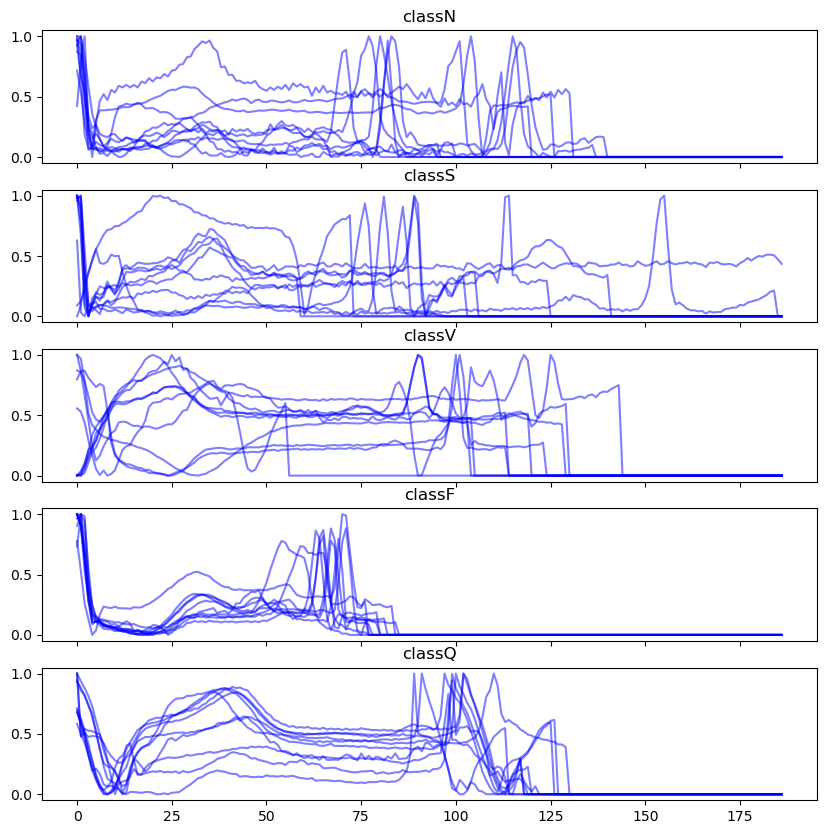

In [6]:
def plot(x_data, y_data, classes=range(5), plots_per_class=10):
    
    f, ax = plt.subplots(5, sharex=True, sharey=True, figsize=(10,10))
    for i in classes:
        
        for j in range(plots_per_class):
            ax[i].set_title("class"+ classmap(i))
            ax[i].plot(x_data[y_data == i].iloc[j,:], color="blue", alpha=.5)
            
plot(x_train, y_train)

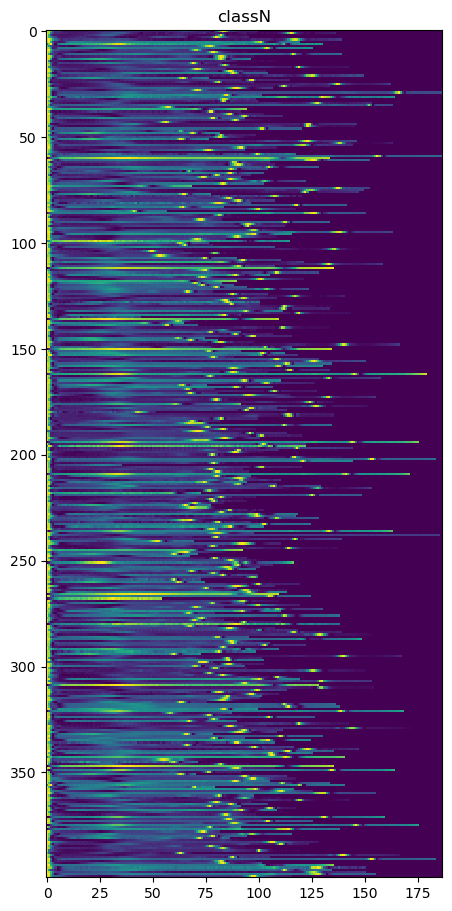

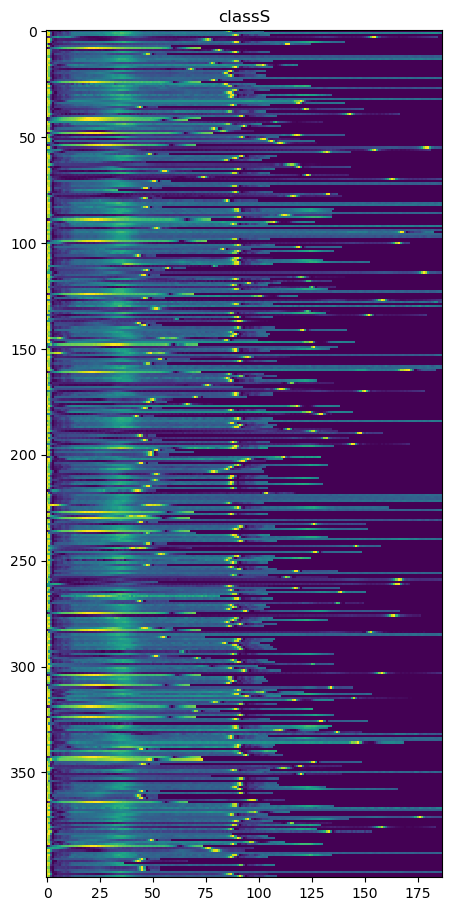

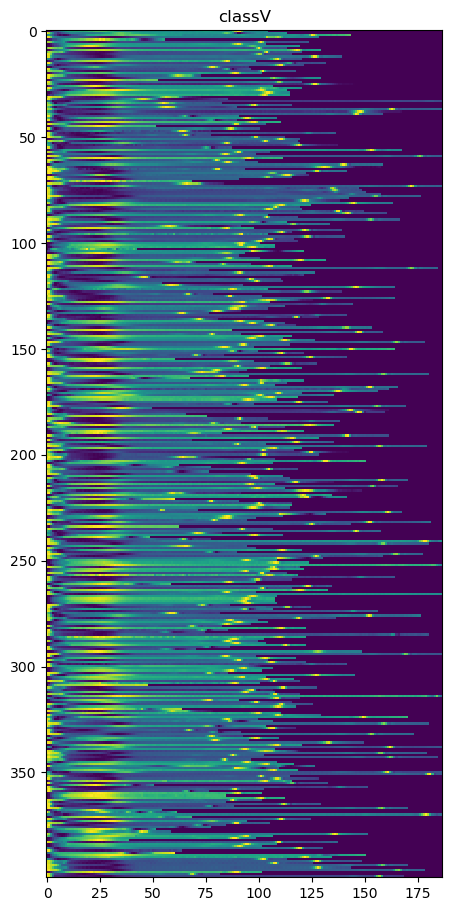

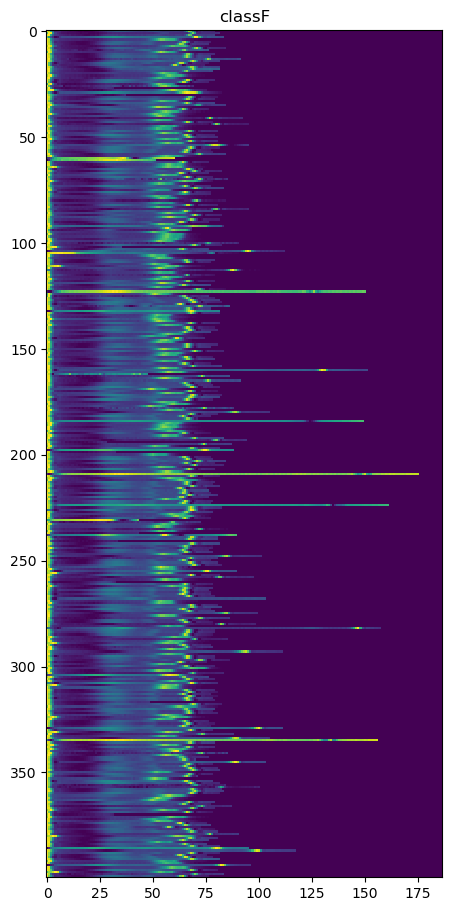

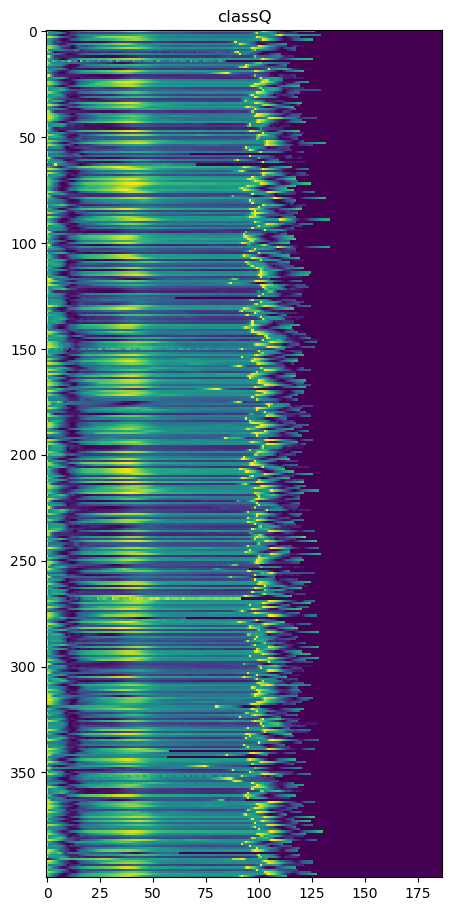

In [7]:
def class_spec(data, classnumber, n_samples):

    fig = plt.figure(figsize=(8,11))
    if type(data)==pd.DataFrame:        
        plt.imshow(data[y_train==classnumber].iloc[:n_samples,:], 
               cmap="viridis", interpolation="nearest")
    else:
        plt.imshow(data[y_train==classnumber][:n_samples,:], 
               cmap="viridis", interpolation="nearest")
    plt.title("class"+ classmap(i))
    plt.show()
    
for i in range(5):
    class_spec(x_train, i, 400)

<Axes: title={'center': 'y_train'}, xlabel='187'>

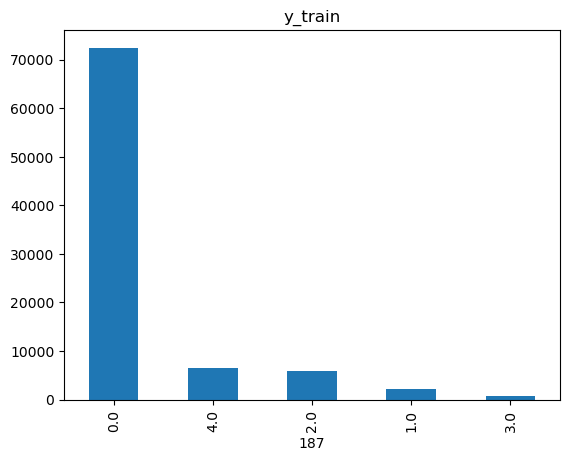

In [8]:
##distribution among classes
y_train.value_counts().plot(kind="bar", title="y_train")

<Axes: title={'center': 'y_test'}, xlabel='187'>

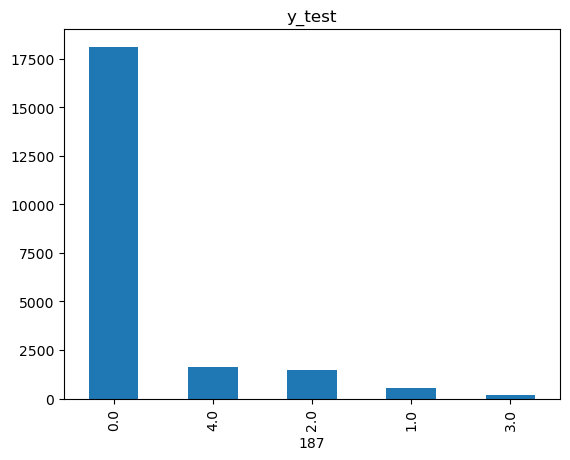

In [9]:
y_test.value_counts().plot(kind="bar", title="y_test")

### Preprocessing

In [10]:
from scipy.signal import gaussian, decimate
from scipy.sparse import csr_matrix

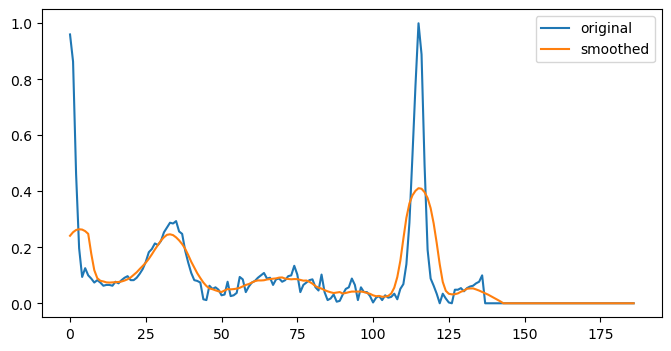

In [18]:
###try manual convolution and sparse metrics and settle out imbalances---very apparent in csv
def gaussian_smoothing(data, window, std):
    gauss = gaussian(window ,std, sym=True)
    data = np.convolve(gauss/gauss.sum(), data, mode='same')
    return data

def gauss_wrapper(data):
    return gaussian_smoothing(data, 12, 7)

fig = plt.figure(figsize=(8,4))
plt.plot(x_train.iloc[1,:], label="original")
plt.plot(gauss_wrapper(x_train.iloc[1,:]), label="smoothed")
plt.legend()

In [19]:
##after data sparsity
def gradient(data, normalize=True):
    data = data.diff(axis=1, periods=3)
    if normalize:
        data = data.apply(lambda x: x/x.abs().max(), axis=1)##force normalization by default
    return data

def preprocess(data): 
    data = data.abs().rolling(7, axis=1).max()
    data = data.fillna(method="bfill",axis=1)
    #data = np.apply_along_axis(gauss_wrapper, 1, data)
    data = decimate(data, axis=1, q=5)
    data[np.abs(data) < .05] = 0
    return pd.DataFrame(data)

x_train_grad = gradient(x_train)
x_test_grad = gradient(x_test)

x_train_preprocessed = preprocess(pd.concat([x_train, x_train_grad, gradient(x_train_grad)], axis=1))
x_test_preprocessed = preprocess(pd.concat([x_test, x_test_grad, gradient(x_test_grad)], axis=1))

MemoryError: Unable to allocate 375. MiB for an array with shape (561, 87554) and data type float64

In [ ]:
plot(x_train_preprocessed, y_train)

In [ ]:
for i in range(5):
    class_spec(x_train_preprocessed, i, 200)

In [ ]:
x_train_sparse = csr_matrix(x_train_preprocessed)

In [ ]:
x_train_preprocessed.sample(2)

In [ ]:
print(x_train_sparse[0])

In [ ]:
plt.imshow(x_train_sparse.toarray(), cmap='viridis')
plt.colorbar()
plt.title('Train Sparse Matrix Heatmap')
plt.show()

In [ ]:
'''nonzero_indices = sparse_matrix.nonzero()
nonzero_values = sparse_matrix.data

# Create a scatter plot of the sparse matrix
plt.scatter(nonzero_indices[1], nonzero_indices[0], c=nonzero_values, cmap='YlGnBu')
plt.colorbar()
plt.title('Sparse Matrix Scatter Plot')
plt.show()'''

In [14]:
del x_train_grad
del x_test_grad    ##deallocate 400 MiB

### Fitting a Scikit-learn benchmark sparse GLM 

For a first intuition, we fit a logistic regression with a one-versus-rest approach for multilabel classification. We use the standard Newton conjugate gradient solver and add class weights according to the number of samples in the data to the loss function.

We regularize the loss with standard L2 penalty.

In [ ]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

In [ ]:
##balanced model
model = LogisticRegression(multi_class="ovr",solver="newton-cg", class_weight="balanced",
                          n_jobs=2, max_iter=150, C=.5)

start_time = time.time()
model.fit(x_train_sparse,y_train)
print("training time {}".format(time.time()-start_time))

In [ ]:
y_predict = model.predict(x_test_preprocessed)
cf = confusion_matrix(y_test,y_predict)
print("accuracy: " + str(accuracy_score(y_test,y_predict)))

In [ ]:
cf_relative = cf / cf.sum(axis=1)[:,None]

In [ ]:
cf

In [ ]:
cf_relative.round(decimals=2)

In [ ]:
print(classification_report(y_test, y_predict))

#### Class 0 is the Normal heart beat, our target for heart disease diagnosis/detection are classes 1 to 4. If we compare the recall between all our targets, there are targets with low recalls (targets 1:S(premature beats) and 3:V(ventricular beats)). This is a big problem since S and V are main causes of heart attacks

We see that our benchmark model performs quite well for the class "4", we however misclassify a significant amount of patients in the "1" and "2" class as "0".

In [ ]:
del x_train
del x_test
del x_train_sparse